In [5]:
from sclibrary.network_reader import NetworkReader
from sclibrary.simplicial_complex import SimplicialComplexNetwork
from sclibrary.plot import SCPlot
import numpy as np
import matplotlib.pyplot as plt

from sclibrary.eigendecomposition import get_eigendecomposition

### Reading data

In [6]:
data_folder = 'data/paper_data'

# read csv
filename = data_folder + '/edges.csv'
delimeter = " "
src_col = 'Source'
dest_col = 'Target'
feature_cols = ['Distance']

G = NetworkReader.read_csv(filename=filename, delimeter=delimeter, 
                           src_col=src_col, dest_col=dest_col, feature_cols=feature_cols)

simplices = G.simplicies(condition="distance", dist_col_name="Distance", dist_threshold=1.5)

# coordinates
filename = data_folder + '/coordinates.csv'
coordinates = NetworkReader.get_coordinates(filename=filename, 
                                            node_id_col="Id", 
                                            x_col='X', 
                                            y_col='Y', 
                                            delimeter=" ")


# create a simplicial complex network
sc = SimplicialComplexNetwork(simplices=simplices)
scplot = SCPlot(sc, coordinates)

### Chebyshev filter design

In [7]:
L1 = sc.hodge_laplacian_matrix(rank=1)
L1L = sc.lower_laplacian_matrix(rank=1)

U1, eigenvals_U1 = get_eigendecomposition(L1)
U1L, eigenvals_U1L = get_eigendecomposition(L1L)

In [8]:
# f0 = np.array([
#     2.25,
#     0.13,
#     1.72,
#     -2.12,
#     1.59,
#     1.08,
#     -0.30,
#     -0.21,
#     1.25,
#     1.45,
# ])

# f = np.array([
#     2.90,
#     0.25, 
#     1.78,
#     -1.50,
#     1.76,
#     1.53,
#     1.32,
#     0.08,
#     0.67, 
#     1.73
# ])

f = np.array([
    0.2851,
    -0.8824,
    -1.3731,
    1.2467,
    -0.9050,
    0.7202,
    0.5628,
    -1.1828,
    1.3918,
    0.8425
])

In [9]:
# approx largest true eigenvalue using power iteration method
# power iteration
v = np.ones(L1.shape[0])
for i in range(50):
    v = L1 @ v
    v = v / np.linalg.norm(v)
v

array([ 0.05882426, -0.32941538,  0.14631812, -0.38823965,  0.4757335 ,
        0.49026405, -0.30516876,  0.31969932,  0.12266404, -0.19703528])

In [10]:
_, _, f_g = sc.get_hodgedecomposition(flow=f)

print(f)
print(f_g)

[ 0.2851 -0.8824 -1.3731  1.2467 -0.905   0.7202  0.5628 -1.1828  1.3918
  0.8425]
[-0.64 -0.31 -1.02  0.32 -0.71  0.17  1.11 -0.24  1.    1.24]


In [11]:
# estimate largest eigenvalue using power iteration method
v = np.ones(L1L.shape[0])
for i in range(50):
    v = L1L @ v
    v = v / np.linalg.norm(v)

print("v", v)
# mean of the largest eigenvalue
lamda_g_max = np.mean(L1L @ v / v)
print("lamda_g_max", lamda_g_max)

v [ 0.05882426 -0.32941538  0.14631812 -0.38823965  0.4757335   0.49026405
 -0.30516876  0.31969932  0.12266404 -0.19703528]
lamda_g_max 5.4879826825028015


In [12]:
from chebpy import chebfun

# cut off frequency - gradient
cut_off_freq_g = 0.01
steep = 100
# logistic function to perform gradient component extraction
g_g = lambda lam: 1 / (1 + np.exp(-steep * (lam - cut_off_freq_g)))
g_g_cheb = chebfun(g_g, [0, lamda_g_max], 100)
# filter coefficients
coeffs_g = g_g_cheb.funs[0].coeffs
coeffs_g

array([ 9.75247591e-01,  4.93662867e-02, -4.89526174e-02,  4.82695494e-02,
       -4.73265143e-02,  4.61364404e-02, -4.47154865e-02,  4.30827118e-02,
       -4.12596907e-02,  3.92700846e-02, -3.71391788e-02,  3.48933998e-02,
       -3.25598222e-02,  3.01656793e-02, -2.77378881e-02,  2.53025993e-02,
       -2.28847825e-02,  2.05078542e-02, -1.81933560e-02,  1.59606882e-02,
       -1.38269010e-02,  1.18065464e-02, -9.91158923e-03,  8.15137767e-03,
       -6.53266749e-03,  5.05969801e-03, -3.73431303e-03,  2.55612109e-03,
       -1.52268809e-03,  6.29755249e-04,  1.28524641e-04, -7.59339874e-04,
        1.27096795e-03, -1.67252543e-03,  1.97372507e-03, -2.18464518e-03,
        2.31551510e-03, -2.37652027e-03,  2.37762901e-03, -2.32844289e-03,
        2.23807127e-03, -2.11503022e-03,  1.96716531e-03, -1.80159715e-03,
        1.62468822e-03, -1.44202913e-03,  1.25844209e-03, -1.07799955e-03,
        9.04055321e-04, -7.39286150e-04,  5.85741170e-04, -4.44897225e-04,
        3.17717934e-04, -

Text(0.5, 1.0, 'Frequency response on the gradient eigen_values - chebyshev approx.')

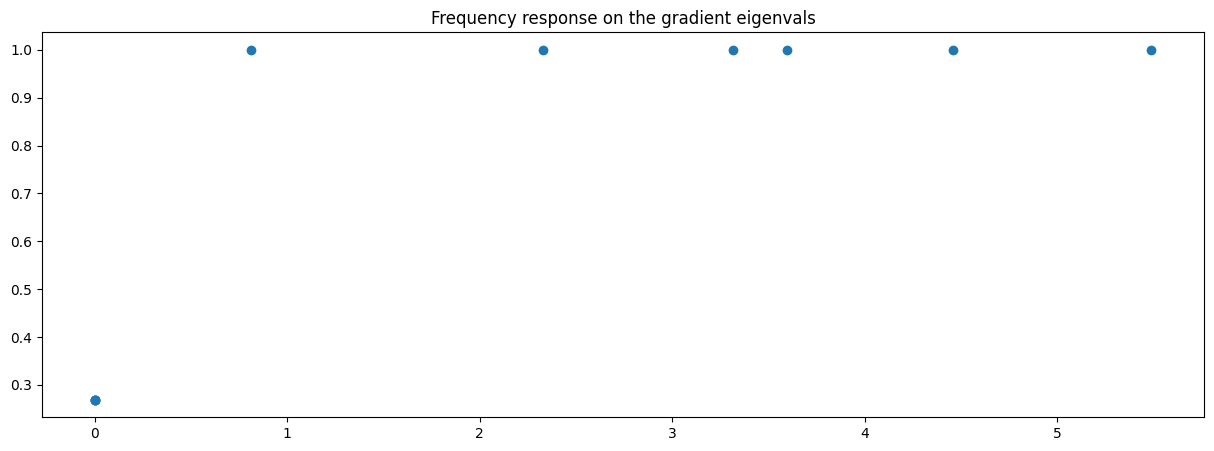

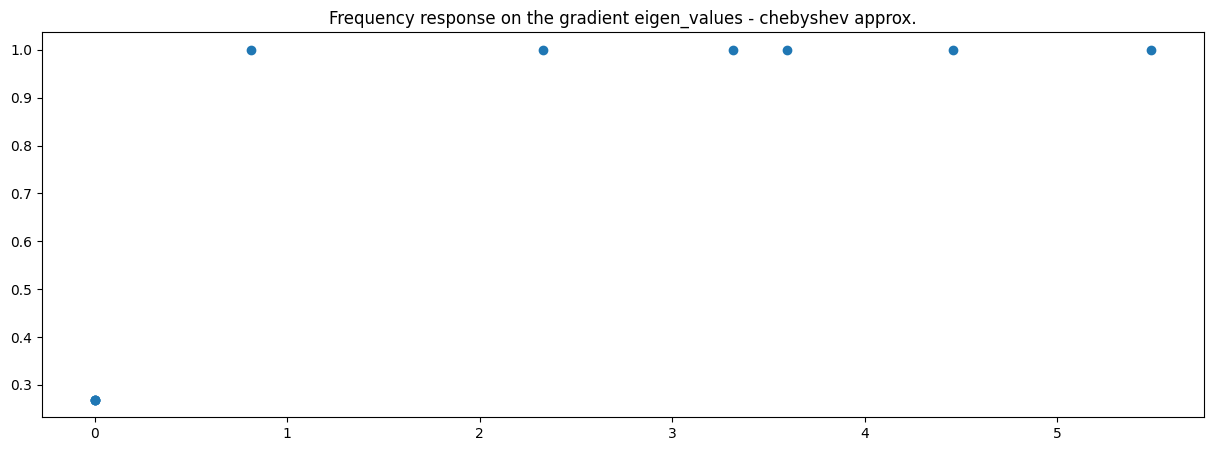

In [13]:
# plot the continuous frequency response 
plt.figure(figsize=(15, 5))
plt.scatter(eigenvals_U1L, g_g(eigenvals_U1L))
plt.title("Frequency response on the gradient eigenvals")

plt.figure(figsize=(15, 5))
plt.scatter(eigenvals_U1L, g_g_cheb(eigenvals_U1L))
plt.title("Frequency response on the gradient eigen_values - chebyshev approx.")

difference 1.913538576985806


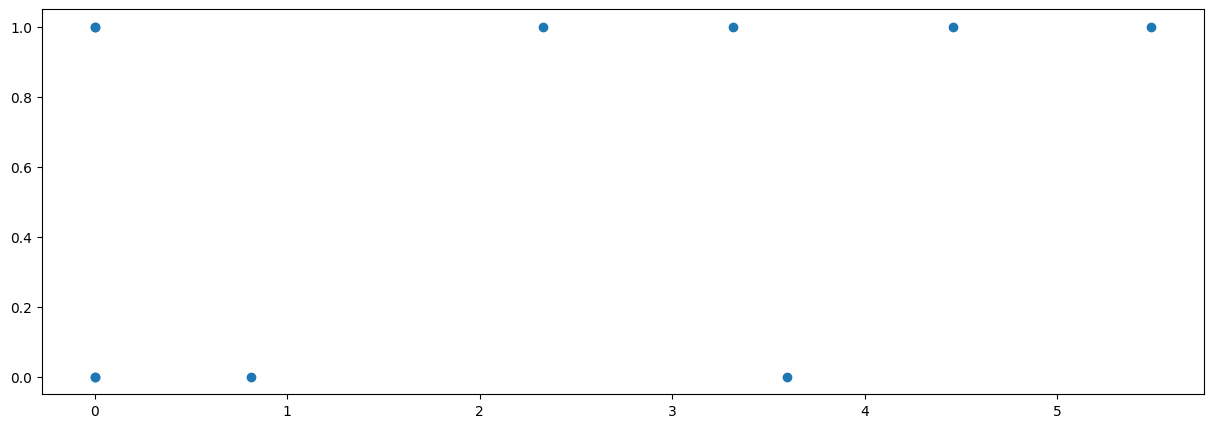

In [14]:
component = "gradient"

# the ideal frequency response
u_g, _ = sc.get_eigendecomposition(component)
h_g_ideal = sc.get_component_coefficients(component)
H_g_ideal = U1L @ np.diag(h_g_ideal) @ U1L.T

# difference 
print("difference", np.linalg.norm(H_g_ideal - u_g @ u_g.T))

# pplo the ideal frequency response
plt.figure(figsize=(15, 5))
plt.scatter(eigenvals_U1L, h_g_ideal)

In [35]:
import numpy as np
# perform a transformation to shit the domain to [0, lambda_g_max]
alpha_g = lamda_g_max / 2
points = (eigenvals_U1L - alpha_g) / alpha_g

def chebyshev_term(l1, L1L):
    if l1 == 0:
        return np.eye(L1L.shape[0])
    elif l1 == 1:
        return (2 / lamda_g_max) * L1L - np.eye(L1L.shape[0])
    else:
        return 2 * chebyshev_term(1, L1L) @ chebyshev_term(l1 - 1, L1L) - chebyshev_term(l1-2, L1L) 
    
    
# implement
# Hl = (1/2) * c(l, 0) * I + sum(l1=1, L) c(l, l1) * P(l1)(L1L)
def calculate_Hl(c, L, L1L):
    #I = np.eye(L1L.shape[0])
    Hl = (1/2) * c[0] 
    
    for l1 in range(1, L+1):
        Hl += c[l1] * chebyshev_term(l1, L1L)
        
    return Hl

Hl = calculate_Hl(coeffs_g, 10, L1L)
Hl

array([[0.32680574, 0.6042362 , 0.55962344, 0.3195357 , 0.44301104,
        0.46979615, 0.5006477 , 0.501385  , 0.49703365, 0.48327244],
       [0.6042362 , 0.26945399, 0.62206384, 0.59836014, 0.39471509,
        0.44803055, 0.51259929, 0.51596376, 0.50110009, 0.47276012],
       [0.55962344, 0.62206384, 0.31378183, 0.5500642 , 0.62486034,
        0.53042694, 0.42404194, 0.45677224, 0.47459989, 0.50545144],
       [0.3195357 , 0.59836014, 0.5500642 , 0.32092968, 0.43932785,
        0.4658582 , 0.49957539, 0.50220255, 0.49169024, 0.47711148],
       [0.44301104, 0.39471509, 0.62486034, 0.43932785, 0.27225049,
        0.57002018, 0.39906644, 0.42843228, 0.4611236 , 0.52031511],
       [0.46979615, 0.44803055, 0.53042694, 0.4658582 , 0.57002018,
        0.35070892, 0.62092239, 0.5805325 , 0.52607559, 0.43316688],
       [0.5006477 , 0.51259929, 0.42404194, 0.49957539, 0.39906644,
        0.62092239, 0.35658497, 0.395     , 0.4334518 , 0.52607559],
       [0.501385  , 0.51596376, 0.4567722

In [36]:
import numpy as np

# truncated order 
K_trunc = range(15)

H_g_cheb_approx_out = np.zeros((len(K_trunc), L1L.shape[0], L1L.shape[1]))

for k in range(len(K_trunc)):
    H_g_cheb_approx_out[k:, :, :] = calculate_Hl(coeffs_g, k, L1L)

In [37]:
errors_g_response = np.zeros((len(K_trunc)))
errors_filter = np.zeros((len(K_trunc)))

f_g_cheb = np.zeros((L1L.shape[0], len(K_trunc)))
f_g_cheb_tilde = np.zeros((L1L.shape[0], len(K_trunc)))

error_g_tilde = np.zeros((len(K_trunc)))
error_g = np.zeros((len(K_trunc)))

for k in range(len(K_trunc)):
    g_g_cheb_approx = np.diag(U1L.T @ np.squeeze(H_g_cheb_approx_out[k, :, :]) @ U1L)
    # compute the error
    errors_g_response[k] = np.linalg.norm(g_g_cheb_approx - h_g_ideal) / np.linalg.norm(h_g_ideal)
    errors_filter[k] = np.linalg.norm(np.squeeze(H_g_cheb_approx_out[k, :, :]) - H_g_ideal, 2)
    
    f_g_cheb[:, k] = np.squeeze(H_g_cheb_approx_out[k, :, :]) @ f
    f_g_cheb_tilde[:, k] = U1 @ f_g_cheb[:, k]
    
    error_g_tilde[k] = np.linalg.norm(f_g_cheb_tilde[:, k] - U1.T * f_g) / np.linalg.norm(U1.T * f_g)
    error_g[k] = np.linalg.norm(f_g_cheb[:, k] - f_g) / np.linalg.norm(f_g)
    
errors_filter


array([4.61537281, 4.59062935, 4.58469036, 4.59148913, 4.61846073,
       4.62880391, 4.61621223, 4.59781505, 4.55990517, 4.53509095,
       4.53575416, 4.5427622 , 4.55968307, 4.57059518, 4.55967961])

In [38]:
error_g_tilde, error_g

(array([1.64452207, 1.61679398, 1.64947106, 1.73602506, 1.78907582,
        1.85777356, 1.92806034, 1.94752349, 1.99288855, 2.03287731,
        2.08140848, 2.17271413, 2.24533819, 2.29639594, 2.3574129 ]),
 array([1.04486235, 1.02796333, 1.01756191, 1.03080046, 1.04577025,
        1.0365826 , 1.05557205, 1.05507183, 1.07453607, 1.07742072,
        1.09449966, 1.10328876, 1.10752247, 1.11278695, 1.13985376]))

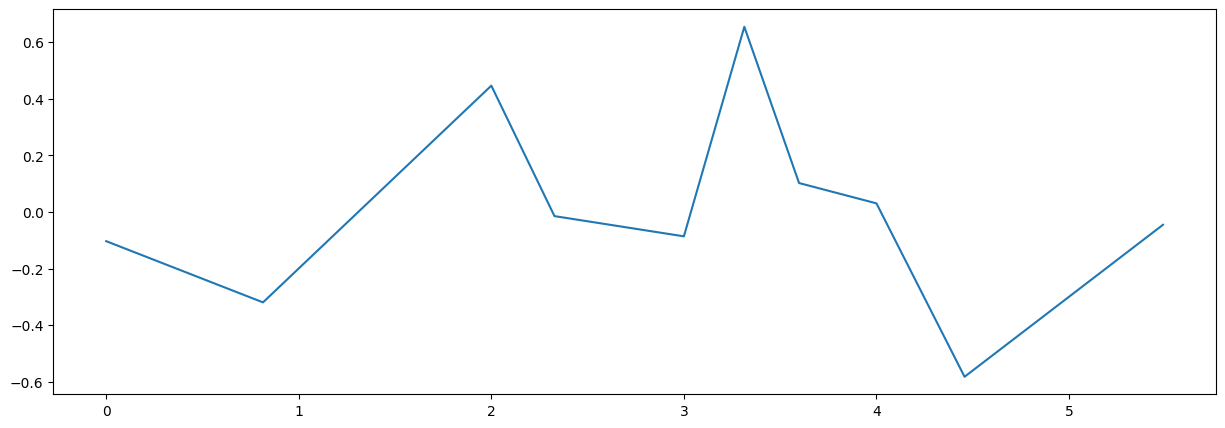

In [39]:
plt.figure(figsize=(15, 5))
plt.plot(eigenvals_U1, f_g_cheb_tilde[:, 1])